## Robust Model

In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

/Users/davidtruhlar/Documents/FIIT/BP/5GDigitalTwin/Implementation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Global variables
BATCH_SIZE = 128
EPOCHS = 100

In [3]:
# Get the class weights from a JSON file
with open('./json/class_weights.json', "r") as f:
    class_weight_dict = json.load(f)

In [4]:
# Preprocessed data
X_train = np.load('preprocessed_data/X_train.npy')
y_train = np.load('preprocessed_data/y_train.npy')
X_test = np.load('preprocessed_data/X_test.npy')
y_test = np.load('preprocessed_data/y_test.npy')

In [5]:
# Transform the y_train and y_test labels to categorical
y_train_cat = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_cat = to_categorical(y_test, num_classes=len(np.unique(y_train)))

In [6]:
# Model definition
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(60, X_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(32))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

/Users/davidtruhlar/Documents/FIIT/BP/5GDigitalTwin/Implementation/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [9]:
# Train the model
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.4585 - loss: 1.4023 - val_accuracy: 0.5489 - val_loss: 1.1260
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.5715 - loss: 1.0647 - val_accuracy: 0.6242 - val_loss: 0.9048
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.6357 - loss: 0.9014 - val_accuracy: 0.6782 - val_loss: 0.8186
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.6718 - loss: 0.8218 - val_accuracy: 0.6945 - val_loss: 0.7563
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 23s 82ms/step - accuracy: 0.6920 - loss: 0.7716 - val_accuracy: 0.7122 - val_loss: 0.7019
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.7095 - loss: 0.7311 - val_accuracy: 0.7186 - val_loss: 0.6804
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.7115 - loss: 0.7094 - val_accuracy: 0.7132 - val_loss: 0.6742
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.7137 - loss: 0

274/274 ━━━━━━━━━━━━━━━━━━━━ 37s 137ms/step


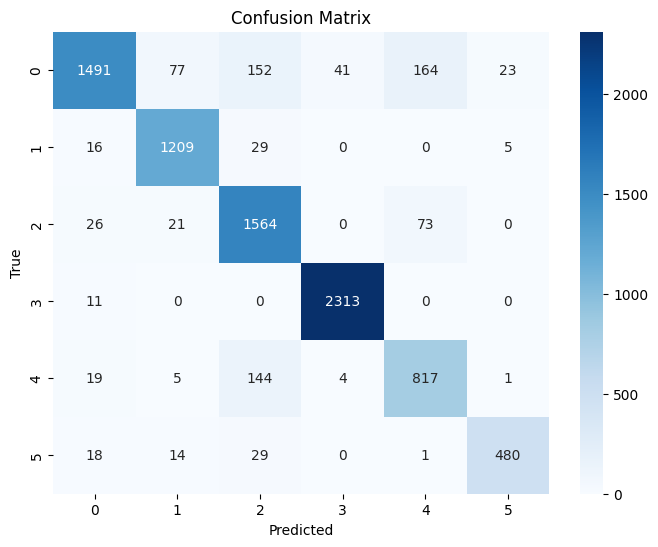

In [10]:
# Predictions
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [11]:
# Classification report
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.943     0.765     0.845      1948
           1      0.912     0.960     0.935      1259
           2      0.815     0.929     0.868      1684
           3      0.981     0.995     0.988      2324
           4      0.774     0.825     0.799       990
           5      0.943     0.886     0.913       542

    accuracy                          0.900      8747
   macro avg      0.895     0.893     0.892      8747
weighted avg      0.905     0.900     0.900      8747



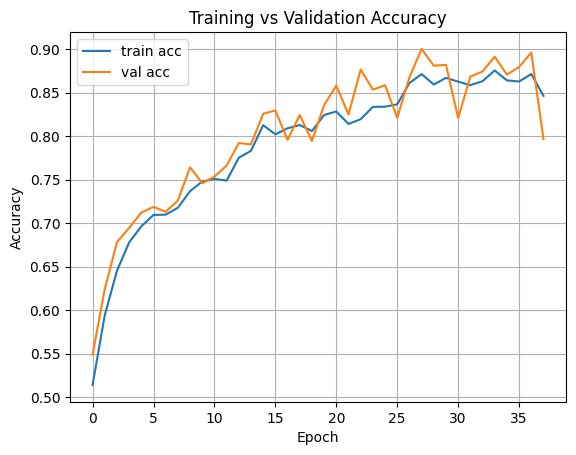

In [12]:
# Plot the training history
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Save the model
model.save('trained_models/lstm_robust_model.h5')
model.save('trained_models/lstm_robust_model.keras')